# Evaluate the Best Number Of Topics With Our LDA Model Approach
- Now that we have understood how LDA might work though the previous EDA exploration of the covid cord19 dataset with the LDA model, we can now:
- 1. Quantitatively evaluate topic models through the measure of topic coherence 
- 2. Explore this by using the gensim python package this time


- It is assumed that probabilistic models such as LDA provide a meaningful and useful representation of the latent space
- Evaluating the topics and their relevance, finding the right number of topics appear difficult and there are indeed no golden standards to compare between corpus and especially the one we have about covid 19!

- However, it is very important to identify if a topic model is good or bad based on its output
- Objective measures regarding the quality of the output are needed
- To see if the correct thing has been done, we use our implicit knowledge about the subject matter and some eyeballing
- In an ideal world, we would like to have a metric and lucklily for us the LDA topic model presents what is called topic coherence that will help us assess the coherence of our LDA model


Finally, the common approaches used in the evaluation of the coherence of a topic model are as follows:
### Eye Balling Methods
- Looking at the top N words in the distribution of each topic
- Looking at the words across topics to see if topics have some sort of logical proximity, when applicable
### Intrinsic Evalution metrics
- Being able to interpet the topics
### Our Own Judgment
- Confirming some sort of topic emerge in the ditribution of a topic


# Using Topic Coherence to Assess the LDA Model

### The case with perplexity:
    - Perplexity is widely used for language model evaluation
    - It captures the level of surprise of a topic model whenever it encounters new data --> measured with the normalized log-likelihood of a test set
    - Perplexity measures how probable some new unseen data is given the model
### Issue with Perplexity
However, this metric used to assess the interpretability and ultimately the coherence of a topic to the human mind prove to sometimes be not useful

### A motivation for topic coherence
Given perplexity does not reliably help with the assessment of the topics generated by a topic model, topic coherence can be used to evaluate the coherence  between topics inferred by a model

### What is topic coherence
It scores each topic by measuring the degree of semantic similarity between high scoring words in the topic. It will help us distinguish between topics that semantically interpretable and topics that are simply due to artificial statistical inference

### Clarification about coherence
Text/Topics are said to be coherent, if they support each other. A coherent fact within a topic is a topic that is aligned with the meaning of the context, and the various meanings of the other facts/group of words. An example of a coherent fact in a topic in the context of the cord19 datasets/topic modelling are "Covid 19 is a respiratory disease", "Covid 19 patients have their respiratory function affected", "Covid 19 might severely damage the lung"

### Coherence measures
https://palmetto.demos.dice-research.org/ --> for the 6 coherence metrics below

- C_v --> based on a sliding window, one set segmentation of the top words and an indirect confirmation metric that uses cosine similarity and Normalized Pointwise Mutual Information (NPMI).
- C_p --> based also on a sliding window, one preceding segmentation of the top words and the confirmation measure of the Fitelson's coherence
- C_uci --> again based on a sliding window, Pointwise Mutual Information (PMI) of all word pairs of the given top words
- C_umasss --> document cooccurence counts, one precedeing segmentation and a logatihmic conditional probability as a confirmation measure
- C_npmi --> enhanced C_uci with NPMI this time
- C_a --> based on a context window, pairwise comparison of the top words and an indirect confirmation that uses NPMI + cosine similarity

https://en.wikipedia.org/wiki/Pointwise_mutual_information#:~:text=Pointwise%20mutual%20information%20(PMI)%2C,average%20of%20all%20possible%20events.--> PMI and NPMI

There are more coherence metrics we could detail here but above are the main ones




## Loading Data


In [1]:
import pandas as pd
papers = pd.read_csv("C:/projects/machineLearning/hecCourse/metadataWithQuotationLabels.csv", usecols=['title', 
                                                                                                      'abstract', 
                                                                                                      'publish_time', 
                                                                                                      'authors', 
                                                                                                      'year',  
                                                                                                      'refid',
                                                                                                      'nbQuotations', 
                                                                                                      'references', 
                                                                                                      'cord_uid'])

In [2]:
# Print head
papers.head()
papers.shape

(93241, 9)

## Data Cleaning

In [3]:
# only keep rows with abstracts
papers = papers[-(papers['abstract'].isnull())]
# only keep rows with number of citations
papers = papers[-(papers['nbQuotations'].isna())]
# drop rows with NaN or NA
papers = papers.dropna()

In [4]:
papers = papers[-(papers['nbQuotations'].isna())]
sum(papers['nbQuotations'].isna())

0

## Only select a random subset of the articles to make the proof of concept much faster to run

In [5]:
import random
random.seed(10)
def selectRandomArticles(num, data):
    articleListIndex = []
    for _ in range(0, num):
        articleListIndex.append(random.randint(1,len(data)))
    return articleListIndex

idx = selectRandomArticles(25000, papers[-(papers['nbQuotations'].isna())])
idxDf = pd.DataFrame(idx, columns = ['index'])
idxDf.to_csv('C:/projects/machineLearning/hecCourse/ArticlesForAnalysis.csv', encoding='utf-8', index=False)

# Extract ID and abstract from dataset
papers = papers[papers.index.isin(idx)]
papers.shape

(21955, 9)

In [6]:
nbNull = sum(papers['abstract'].isnull())
print(f'Number of rows with no abstract is {nbNull}')

Number of rows with no abstract is 0


In [7]:
nbAbstracts = len(papers['abstract'])
print(nbAbstracts)

21955


## Removing the accents

In [8]:
# removing first the accents
import unidecode

def remove_accented_chars(text):
    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    return text


papers['abstract'] = papers.apply(lambda x: remove_accented_chars(x['abstract']), axis=1)
print("The potential accents have been removed from the abtracts")

The potential accents have been removed from the abtracts


## Remove lower casing and punctuation

In [9]:
# Load the regular expression library
import re
# Remove punctuation
papers['paper_text_processed'] = papers['abstract'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
papers['paper_text_processed'].head()

2     surfactant protein-d (sp-d) participates in th...
6     recent evidence suggests that critically ill p...
7     the 21st international symposium on intensive ...
13    we examined the role of the microtubule cytosk...
20    lactococcus lactis the model lactic acid bacte...
Name: paper_text_processed, dtype: object

## Tokenize words and clean up text (unenecessary characters)

In [10]:
%%time
from tqdm import tqdm
import gensim
from gensim.utils import simple_preprocess
def sent_to_words(sentences):
    for sentence in tqdm(sentences):
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data = papers.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1]) # We are displaying only the very first tokenization

100%|██████████| 21955/21955 [00:08<00:00, 2468.85it/s][['surfactant', 'protein', 'sp', 'participates', 'in', 'the', 'innate', 'response', 'to', 'inhaled', 'microorganisms', 'and', 'organic', 'antigens', 'and', 'contributes', 'to', 'immune', 'and', 'inflammatory', 'regulation', 'within', 'the', 'lung', 'sp', 'is', 'synthesized', 'and', 'secreted', 'by', 'alveolar', 'and', 'bronchiolar', 'epithelial', 'cells', 'but', 'is', 'also', 'expressed', 'by', 'epithelial', 'cells', 'lining', 'various', 'exocrine', 'ducts', 'and', 'the', 'mucosa', 'of', 'the', 'and', 'genitourinary', 'tracts', 'sp', 'collagenous', 'calcium', 'dependent', 'lectin', 'or', 'collectin', 'binds', 'to', 'surface', 'glycoconjugates', 'expressed', 'by', 'wide', 'variety', 'of', 'microorganisms', 'and', 'to', 'associated', 'with', 'the', 'surface', 'of', 'various', 'complex', 'organic', 'antigens', 'sp', 'also', 'specifically', 'interacts', 'with', 'glycoconjugates', 'and', 'other', 'molecules', 'expressed', 'on', 'the', '

## Let us now do the phrase modelling with bi grams and tri grams

- Bigrams --> Two words frequently occuring together in a document
- Trigram --> Three words frequently occuring together in a document

We will use the gensim phrase model implementation
- gensim.models.Phrases
- The important hyperparameters to pass in the gensim phrase model are:
    - min count: (float, optional) --> "Ignore all words and bigrams with total collected count lower than this value."
    - threshold (float, optional) – Represent a score threshold for forming the phrases (higher means fewer phrases). A phrase of words a followed by b is accepted if the score of the phrase is greater than threshold. Heavily depends on concrete scoring-function, see the scoring parameter.

### The higher the values of min count and threshold, then the harder for the words to be combined 

In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

### Removing the stop words, making the trigrams, the bigrams and lemmatizing

In [12]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stopWords = pd.read_csv("C:/projects/machineLearning/hecCourse/stopWords.csv", usecols=['index'])
stopWords = list(stopWords['index'])
stop_words.extend(stopWords)

### Below is our list of stop words that will not be considered as part of the topic modelling

In [14]:
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [15]:
from tqdm import tqdm
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in tqdm(texts):
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [16]:
import sys
!{sys.executable} -m pip install spaCy
!{sys.executable} -m spacy download en_core_web_sm

You should consider upgrading via the 'C:\Users\franc\.virtualenvs\machineLearningProject-YX0hXYec\Scripts\python.exe -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
You should consider upgrading via the 'C:\Users\franc\.virtualenvs\machineLearningProject-YX0hXYec\Scripts\python.exe -m pip install --upgrade pip' command.


### Importing the NLP spacy package

In [17]:
import spacy  
import en_core_web_sm ## workaround in case of installation error, I had to do it
nlp = en_core_web_sm.load() ## workaround in case of installation error, I had to do it https://www.xspdf.com/resolution/50342159.html

In [18]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

100%|██████████| 21955/21955 [08:27<00:00, 43.25it/s]
[['surfactant', 'protein', 'innate', 'inhale', 'microorganism', 'organic', 'antigen', 'contribute', 'immune', 'regulation', 'synthesize', 'secrete', 'alveolar', 'also', 'epithelial_cell', 'line', 'exocrine', 'duct', 'genitourinary', 'tract', 'collagenous', 'calcium', 'dependent', 'bind', 'surface', 'glycoconjugate', 'microorganism', 'associate', 'surface', 'complex', 'organic', 'antigen', 'also', 'interact', 'surface', 'macrophage', 'neutrophil', 'lymphocyte', 'bind', 'lipid', 'mixture', 'deficient', 'abnormal', 'accumulation', 'surfactant', 'lipid', 'respond', 'abnormally', 'respiratory', 'virus', 'bacterial', 'phenotype', 'macrophage', 'isolate', 'lung', 'alter', 'circumstantial', 'abnormal', 'oxidant', 'metabolism', 'contribute', 'deficient', 'accumulation', 'appropriately', 'oligomerize', 'human', 'lung', 'disease']]


## Data Transformation : Getting the Corpus and the Dictionary

- Note the LDA model need to have the following two inputs
    - A dictionary of the transformed abstracts --> data_lemmatized it is litteraly a look up table of the words and their associated ids
    - A corpus of the frequency of each word --> corpus --> a list associating each id to its words frequency/count

In [19]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])  

[[(0, 2), (1, 1), (2, 2), (3, 2), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2), (32, 2), (33, 1), (34, 2), (35, 1), (36, 2), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 3), (49, 2), (50, 1), (51, 1), (52, 1)]]


## Let us now create our Base Model

- Everything that is needed for a base LDA model that we will use for assessment of the Topic model with hyper parameter tuning  is avialble
- But in addition to the corpus and the dictionary, we need the number of topics which is a hyperparameter
- Other parameters such as the alpha and the eta are also required in hyper parameter tuning because they also affect the sparsity of the topics
- We also need to vary the chunksize and the passes:
    - chunksize: chunksize controls how many documents are processed at a time in the training algorithm. Increasing chunksize will speed up training, at least as long as the chunk of documents easily fit into memory.
    - passes controls how often we train the model on the entire corpus (set to 10). Another word for passes might be “epochs”. iterations is somewhat technical, but essentially it controls how often we repeat a particular loop over each document. It is important to set the number of “passes” and “iterations” high enough.

In [20]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=5000,
                                       passes=10,
                                       per_word_topics=True)

### Viewing the topics created by the baseline LDA model

- Bear in mind we have chosen 10 topics, where each topic is a combination of keywords, and each keyword contributes a certain weight to the topic

In [21]:
# Seeing the keywords for each topic and the importance of the keyword in each topic using the lda_model.print_topics() method
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.007*"patient" + 0.007*"result" + 0.006*"use" + 0.005*"water" + '
  '0.004*"high" + 0.004*"die" + 0.004*"group" + 0.004*"system" + 0.004*"model" '
  '+ 0.003*"increase"'),
 (1,
  '0.026*"virus" + 0.021*"cell" + 0.017*"infection" + 0.012*"protein" + '
  '0.011*"viral" + 0.009*"human" + 0.008*"disease" + 0.007*"host" + '
  '0.006*"vaccine" + 0.006*"result"'),
 (2,
  '0.025*"cell" + 0.009*"patient" + 0.008*"cat" + 0.005*"use" + '
  '0.004*"transplantation" + 0.004*"report" + 0.004*"infection" + '
  '0.004*"human" + 0.004*"stem" + 0.004*"system"'),
 (3,
  '0.013*"use" + 0.009*"gene" + 0.008*"sequence" + 0.007*"base" + '
  '0.006*"analysis" + 0.006*"protein" + 0.006*"structure" + 0.005*"method" + '
  '0.005*"also" + 0.005*"result"'),
 (4,
  '0.010*"student" + 0.009*"medical" + 0.009*"covid" + 0.008*"patient" + '
  '0.008*"pandemic" + 0.008*"practice" + 0.006*"clinical" + 0.006*"use" + '
  '0.006*"result" + 0.006*"care"'),
 (5,
  '0.012*"health" + 0.011*"model" + 0.011*"covid" + 0.0

## Calculating the coherence of the topics

In [22]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4122749065545249


## The higher the c_v coherence score, the better and here at 0.55 then our coherence score show our topic model baseline is acceptable with an okay score

# Hyper-parameter tuning of our Topic Model

## description text TBD 

In [23]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [166]:
import numpy as np
from tqdm import tqdm
investigate = True
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.25)), 
               # gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.5)), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# takes a very long time to run 
if investigate:
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in tqdm(topics_range):
            # iterate through alpha values
            for a in tqdm(alpha):
                # iterare through beta values
                for b in tqdm(beta):
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
    modelResults = pd.DataFrame(model_results)
    modelResults.to_csv('C:/projects/machineLearning/hecCourse/lda_tuning_results.csv', index=False)

████████  | 4/5 [08:02<01:59, 119.65s/it]

100%|██████████| 5/5 [10:05<00:00, 121.08s/it]

 17%|█▋        | 1/6 [10:05<50:26, 605.40s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [02:04<08:19, 124.84s/it]

 40%|████      | 2/5 [04:13<06:17, 125.98s/it]

 60%|██████    | 3/5 [06:09<04:06, 123.14s/it]

 80%|████████  | 4/5 [08:15<02:03, 123.92s/it]

100%|██████████| 5/5 [10:24<00:00, 124.90s/it]

 33%|███▎      | 2/6 [20:29<40:44, 611.14s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [02:09<08:38, 129.75s/it]

 40%|████      | 2/5 [04:09<06:19, 126.64s/it]

 60%|██████    | 3/5 [06:32<04:23, 131.72s/it]

 80%|████████  | 4/5 [08:40<02:10, 130.61s/it]

100%|██████████| 5/5 [10:46<00:00, 129.35s/it]

 50%|█████     | 3/6 [31:16<31:05, 621.83s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [02:00<08:00, 120.23s/it]

 40%|████      | 2/5 [03:59<05:59, 119.97s/it]

 60%|██████    | 3/5 [05:58<03:59, 119.57s/it]

 80%|████████  | 4/5 [08

PermissionError: [Errno 13] Permission denied: 'C:/projects/machineLearning/hecCourse/lda_tuning_results.csv'

## We then manually found the best set of hyperparameters in the csv file generated in the previous cell

In [24]:
modelResultsFixed = pd.read_csv('C:/projects/machineLearning/hecCourse/bestHyperParamLda.csv')
modelResultsFixed

,Validation_Set,Topics,Alpha,Beta,Coherence
0,100% Corpus,2,0.31,0.91,0.513988
1,100% Corpus,3,0.31,0.91,0.515782
2,100% Corpus,4,0.31,0.91,0.549693
3,100% Corpus,5,0.31,0.91,0.544200
4,100% Corpus,6,0.31,0.91,0.546888
5,100% Corpus,7,0.31,0.91,0.546751
6,100% Corpus,8,0.31,0.91,0.569412
7,100% Corpus,9,0.31,0.91,0.544797
8,100% Corpus,10,0.31,0.91,0.554589


In [25]:
improvement = (modelResultsFixed.loc[6][['Coherence']].astype('float64') - coherence_lda) / (coherence_lda)
print(f'Hyper parameter tuning improved by {improvement[0]} the topic coherence of our LDA model')

Hyper parameter tuning improved by 0.38114640243012976 the topic coherence of our LDA model


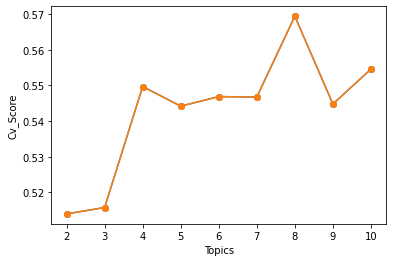

In [26]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots()
ax.plot(modelResultsFixed.Topics, modelResultsFixed.Coherence, marker="o")
ax.set_xlabel("Topics")
ax.set_ylabel("Cv_Score")
ax.plot(modelResultsFixed.Topics, modelResultsFixed.Coherence, marker="o")
plt.savefig('TopicCoherenceVsTopicNumber')
plt.show()

## We train the final model with the hyperparameters that output the best coherence score

In [27]:
import gensim
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           chunksize=5000,
                                           passes=10,
                                           alpha=0.31,
                                           eta=0.91)

In [30]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# Visualize the topics
num_topics = 8
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(num_topics) +'.html')


C:\Users\franc\.virtualenvs\machineLearningProject-YX0hXYec\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
LDAvis_prepared

C:\Users\franc\.virtualenvs\machineLearningProject-YX0hXYec\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.087006 -0.032621       1        1  28.451898
1      0.099413  0.116016       2        1  26.344741
7      0.117527 -0.074469       3        1  22.421853
3     -0.020359  0.101312       4        1   9.931926
0     -0.001227 -0.047106       5        1   5.514865
4     -0.048980 -0.080410       6        1   4.738022
6     -0.072332  0.010210       7        1   1.948557
2     -0.161048  0.007069       8        1   0.648139, topic_info=            Term          Freq         Total Category  logprob  loglift
72       patient  21423.000000  21423.000000  Default  30.0000  30.0000
56          cell   8646.000000   8646.000000  Default  29.0000  29.0000
13057      covid  19287.000000  19287.000000  Default  28.0000  28.0000
52         virus  13369.000000  13369.000000  Default  27.0000  27.0000
399    treatment   5030.000000   5030.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
18       disease      7.599435  10024.805184   Topic8  -7.3548  -2.1459
165      compare      7.018935   4333.432658   Topic8  -7.4343  -1.3867
8      associate      7.076152   5115.460534   Topic8  -7.4262  -1.5445
857          day      6.839358   4332.093012   Topic8  -7.4602  -1.4123
156        viral      6.635734   6198.683204   Topic8  -7.4904  -1.8008

[652 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
37082      1  0.129694  aast
37082      2  0.129694  aast
37082      3  0.129694  aast
37082      4  0.129694  aast
37082      5  0.129694  aast
...      ...       ...   ...
1544       4  0.029661  year
1544       5  0.034307  year
1544       6  0.020727  year
1544       7  0.003931  year
1544       8  0.001072  year

[3783 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 8, 4, 1, 5, 7, 3])